In [2]:
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

Cannot find header.dxf (GDAL_DATA is not defined)


In [3]:
date = '2024-03-22'

day_path = Path.cwd().parent / 'results' / date

nat = pypsa.Network(
    day_path / 'network_flex_s_national_solved.nc'
)
bal = pypsa.Network(
    day_path / 'network_flex_s_national_solved_redispatch.nc'
)
nod = pypsa.Network(
    day_path / 'network_flex_s_nodal_solved.nc'
)

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads
INFO:pypsa.io:Imported network network_flex_s_nodal_solved.nc has buses, carriers, generators, links, loads, storage_units


In [4]:
bids = pd.read_csv(Path.cwd().parent/'data'/'base'/date/'bids.csv', index_col=[0,1], parse_dates=True)
offers = pd.read_csv(Path.cwd().parent/'data'/'base'/date/'offers.csv', index_col=[0,1], parse_dates=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_21372\3688615776.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bids = pd.read_csv(Path.cwd().parent/'data'/'base'/date/'bids.csv', index_col=[0,1], parse_dates=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_21372\3688615776.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  offers = pd.read_csv(Path.cwd().parent/'data'/'base'/date/'offers.csv', index_col=[0,1], parse_dates=True)


In [ ]:
default_balancing_prices = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'balancing_prices' / '2022-week16.csv',
    index_col=0
)

In [213]:
default_balancing_prices

,offers,bids
disp,244.870068,-90.857372
wind,150.000000,58.861324
water,297.036574,-9.311891


In [86]:
def get_unit_wholesale_revenue(n, comp, unit):
    if isinstance(unit, str):
        return (
            getattr(n, comp+'_t').p[unit].multiply(
                0.5 * n.buses_t.marginal_price[getattr(n, comp).bus[unit]]
                )
            .rename(unit)
        )
    elif isinstance(unit, pd.Index):
        m_prices = nat.buses_t.marginal_price[getattr(nat, comp).bus[unit]]
        m_prices.columns = unit

        commodities = getattr(nat, comp+'_t').p[unit]

        return (
            commodities.multiply(0.5 * m_prices)
        )
    
    else:
        assert False, 'unit must be either a string or a pd.Index'

wholesale_revenues = []

for comp in ['generators', 'storage_units']:
    for unit in getattr(nat, comp).index:
        wholesale_revenues.append(get_unit_wholesale_revenue(nat, comp, unit))

wholesale_revenues = pd.concat(wholesale_revenues, axis=1)

In [6]:
def process_data(df):
    df = (
        df
        .stack()
        .unstack(1)
        .dropna()
        .groupby(level=1)
        .agg({'price': 'mean', 'vol': 'sum'})
        .sort_values('price')
    )
    return df

In [7]:
actual_bids = process_data(bids)
actual_offers = process_data(offers)

In [8]:
cfd_strike_prices = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'cfd_strike_prices.csv',
    index_col=0,
    parse_dates=True
    )

roc_values = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'roc_values.csv',
    index_col=0).iloc[:,0]

C:\Users\lukas\AppData\Local\Temp\ipykernel_21372\1876736593.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cfd_strike_prices = pd.read_csv(


In [9]:
def get_cfd_revenue(n, strike_prices):

    strike_prices = strike_prices.copy()
    strike_prices.columns = pd.to_datetime(strike_prices.columns)

    strike_prices = (
        strike_prices
        .loc[:,:n.snapshots[4]]
        .iloc[:,-1]
    )

    cfd_plants = strike_prices.index.intersection(n.generators.index)

    cfd_payments = pd.DataFrame(columns=cfd_plants, index=n.snapshots)

    for plant, strike_price in strike_prices.loc[cfd_plants].items():

        price_gap = (
            strike_price - n.buses_t.marginal_price[n.generators.loc[plant, 'bus']]
        )
        cfd_payments.loc[:, plant] = n.generators_t.p[plant] * price_gap * 0.5
    
    return cfd_payments

get_cfd_revenue(nat, cfd_strike_prices).head()

,KPMRW-1,MIDMW-1,DOREW-1,DOREW-2,TRLGW-1,HOWBO-1,HOWBO-3,HOWBO-2,MOWEO-1,MOWEO-2,...,DDGNO-2,DDGNO-1,DDGNO-3,DDGNO-4,HOWAO-2,HOWAO-3,HOWAO-1,TSREP-1,WLNYO-3,WLNYO-4
snapshot,,,,,,,,,,,,,,,,,,,,,
2024-03-22 00:00:00,2751.094753,1108.354721,3800.073328,3206.31187,712.513749,11807.682265,11807.682265,10613.34199,5201.230542,5223.649639,...,6634.609579,8080.61423,7655.318745,8165.673328,33158.534767,9972.491659,23269.147205,0.0,22144.10495,23850.952796
2024-03-22 00:30:00,2815.471573,1289.528965,4126.492687,3481.728205,773.717379,13286.76999,13286.76999,11927.548692,5990.077328,6015.896627,...,6899.825308,8403.633389,7961.336894,8492.092687,34515.215232,10380.515859,24221.203671,0.0,21863.443075,26431.923717
2024-03-22 01:00:00,2991.797696,1370.289021,4384.924868,3699.780357,822.173413,14457.790807,14457.790807,12962.157275,6614.621763,6643.133064,...,7109.801455,8659.373567,8112.465763,8659.373567,35589.323981,10703.556085,24974.964197,0.0,21919.159711,27243.0694
2024-03-22 01:30:00,3225.468027,1441.686467,4691.589858,3958.528942,879.673098,15810.935815,15810.935815,14207.983797,7355.728823,7419.140278,...,7264.621032,8868.498402,8396.769764,8962.84413,36863.900346,11086.887322,25869.403752,0.0,23640.293553,27704.243388
2024-03-22 02:00:00,3464.817031,1574.916832,5039.733864,4252.275447,944.950099,17364.808228,17364.808228,15582.261593,8197.076837,8267.741293,...,7543.861536,9209.389408,8621.556042,9307.361636,38310.873871,11522.06733,26884.823769,0.0,26560.158372,29693.948819


In [249]:
diff = pd.concat((
    bal.generators_t.p - nat.generators_t.p,
    # bal.storage_units_t.p - nat.storage_units_t.p,
), axis=1)

In [11]:
def make_north_south_split(
        n,
        carrier,
        comp,
        threshold=55.3
        ):

    comp_df = getattr(n, comp)
    comp_df['lat'] = comp_df.bus.map(n.buses.y)

    if not isinstance(carrier, str):
        mask = comp_df['carrier'].isin(carrier)
    else:
        mask = comp_df['carrier'].str.contains(carrier)

    north = comp_df.loc[mask & (comp_df['lat'] > threshold)].index
    south = comp_df.loc[mask & (comp_df['lat'] <= threshold)].index

    return north, south


In [39]:
def get_weighted_avg_price(df):
    assert set(df.columns) == {'price', 'vol'}, 'Columns must be price and vol'
    assert not df.empty, 'DataFrame must not be empty'

    return (df['price'] * df['vol']).sum() / df['vol'].sum()

In [12]:
wind_north, wind_south = make_north_south_split(
    bal,
    'wind',
    'generators',
    )

disp_north, disp_south = make_north_south_split(
    bal,
    ['fossil', 'biomass', 'coal'],
    'generators',
    )

water_north, water_south = make_north_south_split(
    nod,
    ['cascade', 'hydro', 'PHS'],
    'storage_units',
    )

In [227]:
revenues = pd.DataFrame(
    0.,
    columns=pd.MultiIndex.from_product(
        [
            ['north', 'south'],
            ['wind', 'disp', 'water'],
            ['wholesale', 'offers', 'bids', 'cfd', 'roc'],
            ],
        ), index=nat.snapshots)

In [243]:
idx = pd.IndexSlice

####              REVENUE OF SOUTHERN WIND GENERATOR

south_wind_offers = diff.loc[:, wind_south].sum(axis=1)
south_wind_offers_total = south_wind_offers.sum()
south_wind_offers_total_actual = (
    actual_offers
    .loc[idx[wind_south.intersection(actual_offers.index), 'vol']]
    .sum()
)

south_disp_offers = diff.loc[
    :, actual_offers.index.intersection(wind_south)
].sum(axis=1)

if south_wind_offers_total > south_wind_offers_total_actual:

    keep_share = south_wind_offers_total_actual / south_wind_offers_total
    transfer_share = 1. - keep_share

else:

    keep_share = south_wind_offers_total_actual / south_wind_offers_total
    transfer_share = 0.

south_wind_transfer = south_wind_offers * transfer_share
south_wind_offers *= keep_share

try:
    south_wind_offers_price = get_weighted_avg_price(
        actual_offers.loc[wind_south.intersection(actual_offers.index)]
    )
    revenues.loc[:, idx['south', 'wind', 'offers']] = (
        south_wind_offers_price
        * south_wind_offers
        / 2
    )
except:
    pass


wind_south_dispatch = bal.generators_t.p.loc[
    :,
    wind_south.intersection(roc_values.index)
    ]

wind_south_roc_revenue = wind_south_dispatch.multiply(
    roc_values.loc[wind_south_dispatch.columns] / 2
)

revenues.loc[:, idx['south', 'wind', 'roc']] = wind_south_roc_revenue.sum(axis=1)

cfd = get_cfd_revenue(bal, cfd_strike_prices)
cfd_revenue = cfd.loc[:, wind_south.intersection(cfd.columns)]
revenues.loc[:, idx['south', 'wind', 'cfd']] = cfd_revenue.sum(axis=1)

revenues.loc[:, idx['south', 'wind', 'wholesale']] = (
    get_unit_wholesale_revenue(
        nat,
        'generators',
        wind_south)
    .sum(axis=1)
)

C:\Users\lukas\AppData\Local\Temp\ipykernel_21372\621393747.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  revenues.loc[:,idx['south', 'wind']].plot()


<Axes: xlabel='snapshot'>

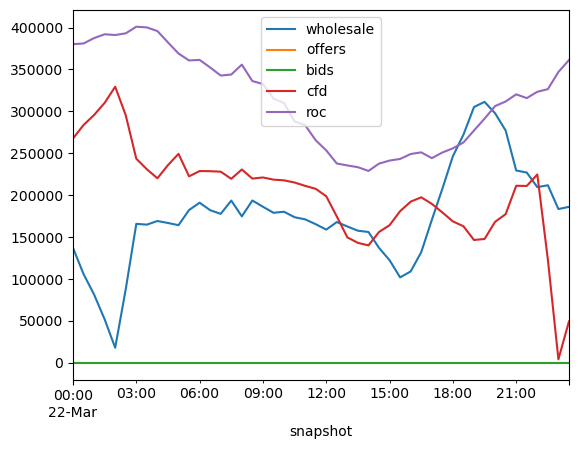

In [229]:
revenues.loc[:,idx['south', 'wind']].plot()

In [ ]:
####              REVENUE OF NORTHERN WIND GENERATOR

revenues.loc[:, idx['north', 'wind', 'wholesale']] = (
    get_unit_wholesale_revenue(
        nat,
        'generators',
        wind_north)
    .sum(axis=1)
)

cfd = get_cfd_revenue(bal, cfd_strike_prices)
cfd_revenue = cfd.loc[:, wind_north.intersection(cfd.columns)]
revenues.loc[:, idx['north', 'wind', 'cfd']] = cfd_revenue.sum(axis=1)

wind_north_dispatch = bal.generators_t.p.loc[
    :,
    wind_north.intersection(roc_values.index)
    ]

wind_north_roc_revenue = wind_north_dispatch.multiply(
    roc_values.loc[wind_north_dispatch.columns] / 2
)

revenues.loc[:, idx['north', 'wind', 'roc']] = wind_north_roc_revenue.sum(axis=1)

north_wind_bids = (
    diff
    .loc[:, wind_north]
    .sum(axis=1)
    .clip(upper=0)
    .abs()
)

if north_wind_bids.sum() > 0:

    actual_north_wind_bid_vol = actual_bids.loc[actual_bids.index.intersection(wind_north), 'vol']

    if actual_north_wind_bid_vol.sum() > 0:
        north_wind_bid_price = get_weighted_avg_price(
            actual_bids.loc[actual_bids.index.intersection(wind_north), :]
        )

    else:
        north_wind_bid_price = default_balancing_prices.loc['wind', 'bids']
    
    revenues.loc[:, idx['north', 'wind', 'bids']] = (
        north_wind_bids
        * north_wind_bid_price
        / 2
    )


north_wind_offers = (
    diff
    .loc[:, wind_north]
    .sum(axis=1)
    .clip(lower=0)
)

if north_wind_offers.sum() > 0:
    
    actual_north_wind_offer_vol = actual_offers.loc[
        actual_offers.index.intersection(wind_north), 'vol'
        ]

    if actual_north_wind_offer_vol.sum() > 0:
        north_wind_offer_price = get_weighted_avg_price(
            actual_offers.loc[actual_offers.index.intersection(wind_north), :]
        )

    else:
        north_wind_offer_price = default_balancing_prices.loc['wind', 'offers']
    
    revenues.loc[:, idx['north', 'wind', 'offers']] = (
        north_wind_offers
        * north_wind_offer_price
        / 2
    )

In [230]:
####              REVENUE OF DISPATCHABLE GENERATORS

disp_offers_actual = (
    actual_offers
    .loc[disp_south.union(disp_north).intersection(actual_offers.index)]
    )

if not disp_offers_actual.empty:
    disp_offers_price = get_weighted_avg_price(disp_offers_actual)
else:
    disp_offers_price = default_balancing_prices.loc['disp', 'offers']

south_disp_offers = (
    diff.loc[
        # :, actual_offers.index.intersection(wind_south)
        :, disp_south
    ]
    .sum(axis=1)
    .clip(lower=0.)
)

assert (south_wind_transfer >= 0).all(), 'Negative transfer of wind offers to dispatchable generators'

south_disp_offers += south_wind_transfer

revenues.loc[:, idx['south', 'disp', 'offers']] = (
    south_disp_offers * disp_offers_price / 2
)

disp_bids_actual = (
    actual_bids
    .loc[disp_south.union(disp_north).intersection(actual_bids.index)]
    )

if not disp_bids_actual.empty:
    disp_bids_price = get_weighted_avg_price(disp_bids_actual)
else:
    disp_bids_price = default_balancing_prices.loc['disp', 'bids']

south_disp_bids = (
    diff.loc[
        # :, actual_bids.index.intersection(wind_south)
        :, disp_south
    ]
    .sum(axis=1)
    .clip(upper=0.)
    .abs()
)

revenues.loc[:, idx['south', 'disp', 'bids']] = (
    south_disp_bids * disp_bids_price / 2
)

In [231]:
north_disp_offers = (
    diff.loc[:, disp_north]
    .sum(axis=1)
    .clip(lower=0.)
)

north_disp_bids = (
    diff.loc[:, disp_north]
    .sum(axis=1)
    .clip(upper=0.)
    .abs()
)

In [232]:
revenues.loc[:, idx['north', 'disp', 'offers']] = (
    north_disp_offers * disp_offers_price / 2
)

revenues.loc[:, idx['north', 'disp', 'bids']] = (
    north_disp_bids * disp_bids_price / 2
)

In [233]:
revenues.loc[:, idx['south', 'disp', 'wholesale']] = (
    get_unit_wholesale_revenue(
        nat,
        'generators',
        disp_south)
    .sum(axis=1)
)

revenues.loc[:, idx['north', 'disp', 'wholesale']] = (
    get_unit_wholesale_revenue(
        nat,
        'generators',
        disp_north)
    .sum(axis=1)
)

In [234]:
####              REVENUE OF HYDRO GENERATORS

def get_water_balancing_revenue(who, units, mode, actual_trades):
    '''
    who: wholesale model
    units: units to consider
    mode: 'offers' or 'bids'
    '''

    print((
        'Implementation of hydropower revenue assumes that hydro'
        'wholesale trading cant be reversed in balancing model.'
        ))

    assert mode in ['offers', 'bids'], 'mode must be either offers or bids'

    actual = actual_trades.loc[actual_trades.index.intersection(units)]

    total_actual_volume = actual['vol'].sum()

    if total_actual_volume == 0:
        return pd.Series(0., index=who.snapshots)
    
    actual_revenue = (actual['price'] * actual['vol']).sum()

    if mode == 'offers':
        kwargs = {'lower': 0.}
    else:
        kwargs = {'upper': 0.}

    trading_profile = who.storage_units_t.p[units].sum(axis=1).clip(**kwargs).abs()

    if trading_profile.sum() == 0:
        return pd.Series(actual_revenue / len(who.snapshots), index=who.snapshots)
    
    trading_profile = trading_profile.div(trading_profile.sum())

    return (
        trading_profile
        .multiply(actual_revenue)
    )

In [235]:
revenues.loc[:, idx['south', 'water', 'wholesale']] = (
    get_unit_wholesale_revenue(
        nat,
        'storage_units',
        water_south)
    .sum(axis=1)
)

revenues.loc[:, idx['north', 'water', 'wholesale']] = (
    get_unit_wholesale_revenue(
        nat,
        'storage_units',
        water_north)
    .sum(axis=1)
)

In [236]:
revenues.loc[:, idx['north', 'water', 'bids']] = (
    get_water_balancing_revenue(
        nat,
        water_north,
        'bids',
        actual_bids)
)

revenues.loc[:, idx['north', 'water', 'offers']] = (
    get_water_balancing_revenue(
        nat,
        water_north,
        'offers',
        actual_offers)
)

revenues.loc[:, idx['south', 'water', 'bids']] = (
    get_water_balancing_revenue(
        nat,
        water_south,
        'bids',
        actual_bids)
)

revenues.loc[:, idx['south', 'water', 'offers']] = (
    get_water_balancing_revenue(
        nat,
        water_south,
        'offers',
        actual_offers)
)

Implementation of hydropower revenue assumes that hydrowholesale trading cant be reversed in balancing model.
Implementation of hydropower revenue assumes that hydrowholesale trading cant be reversed in balancing model.
Implementation of hydropower revenue assumes that hydrowholesale trading cant be reversed in balancing model.
Implementation of hydropower revenue assumes that hydrowholesale trading cant be reversed in balancing model.


In [237]:
def get_water_roc_revenue(
        n,
        actual_bids,
        actual_offers,
        units,
        roc_values
        ):
    '''
    n: network
    units: units to consider
    roc_values: ROC values
    '''

    units = units.copy().intersection(roc_values.index)

    if units.empty:
        return pd.Series(0., index=n.snapshots)

    bid_volume = actual_bids.loc[units.intersection(actual_bids.index)].vol.sum()
    offer_volume = actual_offers.loc[units.intersection(actual_offers.index)].vol.sum()

    units_dispatch = n.storage_units_t.p[units].clip(lower=0.)

    total_dispatch = units_dispatch.sum().sum() * 0.5

    units_dispatch *= (
        (total_dispatch + offer_volume - bid_volume) / total_dispatch
        )
    
    return units_dispatch.multiply(
        roc_values.loc[units_dispatch.columns] / 2
        ).sum(axis=1)


In [238]:
revenues.loc[:, idx['north', 'water', 'roc']] = (
    get_water_roc_revenue(
        nat,
        actual_bids,
        actual_offers,
        water_north,
        roc_values
        )
)

revenues.loc[:, idx['south', 'water', 'roc']] = (
    get_water_roc_revenue(
        nat,
        actual_bids,
        actual_offers,
        water_south,
        roc_values
        )
)

In [241]:
revenues.loc[:, revenues.sum() == 0].columns

MultiIndex([('north',  'wind', 'wholesale'),
            ('north',  'wind',    'offers'),
            ('north',  'wind',      'bids'),
            ('north',  'wind',       'cfd'),
            ('north',  'wind',       'roc'),
            ('north',  'disp',    'offers'),
            ('north',  'disp',       'cfd'),
            ('north',  'disp',       'roc'),
            ('north', 'water',       'cfd'),
            ('south',  'wind',    'offers'),
            ('south',  'wind',      'bids'),
            ('south',  'disp',      'bids'),
            ('south',  'disp',       'cfd'),
            ('south',  'disp',       'roc'),
            ('south', 'water',       'cfd'),
            ('south', 'water',       'roc')],
           )

In [199]:
disp_bids_actual = actual_bids.loc[disp_south.union(disp_north).intersection(actual_bids.index)]
disp_bids_price = get_weighted_avg_price(disp_bids_actual)

disp_bids_actual

,price,vol
AG-NHAV02,46.09,779.209171


In [201]:
diff.loc[:, disp_south].sum(axis=1)

snapshot
2024-03-22 00:00:00    4259.686393
2024-03-22 00:30:00    4312.753996
2024-03-22 01:00:00    4104.867933
2024-03-22 01:30:00    4109.779876
2024-03-22 02:00:00    4217.083940
2024-03-22 02:30:00    4396.056179
2024-03-22 03:00:00    3459.517138
2024-03-22 03:30:00    3453.407662
2024-03-22 04:00:00    3613.513466
2024-03-22 04:30:00    3543.570409
2024-03-22 05:00:00    3489.011288
2024-03-22 05:30:00    3525.325183
2024-03-22 06:00:00    4891.986817
2024-03-22 06:30:00    4612.074493
2024-03-22 07:00:00    4367.363003
2024-03-22 07:30:00    5153.388300
2024-03-22 08:00:00    3234.484253
2024-03-22 08:30:00    3993.802880
2024-03-22 09:00:00    3916.636866
2024-03-22 09:30:00    4068.536180
2024-03-22 10:00:00    3931.397303
2024-03-22 10:30:00    3787.796990
2024-03-22 11:00:00    3960.195634
2024-03-22 11:30:00    4257.654270
2024-03-22 12:00:00    4494.169260
2024-03-22 12:30:00    4760.855889
2024-03-22 13:00:00    4818.477831
2024-03-22 13:30:00    4846.935521
2024-03-22 

In [186]:
actual_bids.loc[disp_north.intersection(actual_bids.index)]

,price,vol
AG-NHAV02,46.09,779.209171


In [189]:
actual_bids.loc[
    disp_south.intersection(actual_bids.index)
    ]

,price,vol


In [192]:
diff[disp_south].sum(axis=1)

snapshot
2024-03-22 00:00:00    4259.686393
2024-03-22 00:30:00    4312.753996
2024-03-22 01:00:00    4104.867933
2024-03-22 01:30:00    4109.779876
2024-03-22 02:00:00    4217.083940
2024-03-22 02:30:00    4396.056179
2024-03-22 03:00:00    3459.517138
2024-03-22 03:30:00    3453.407662
2024-03-22 04:00:00    3613.513466
2024-03-22 04:30:00    3543.570409
2024-03-22 05:00:00    3489.011288
2024-03-22 05:30:00    3525.325183
2024-03-22 06:00:00    4891.986817
2024-03-22 06:30:00    4612.074493
2024-03-22 07:00:00    4367.363003
2024-03-22 07:30:00    5153.388300
2024-03-22 08:00:00    3234.484253
2024-03-22 08:30:00    3993.802880
2024-03-22 09:00:00    3916.636866
2024-03-22 09:30:00    4068.536180
2024-03-22 10:00:00    3931.397303
2024-03-22 10:30:00    3787.796990
2024-03-22 11:00:00    3960.195634
2024-03-22 11:30:00    4257.654270
2024-03-22 12:00:00    4494.169260
2024-03-22 12:30:00    4760.855889
2024-03-22 13:00:00    4818.477831
2024-03-22 13:30:00    4846.935521
2024-03-22 

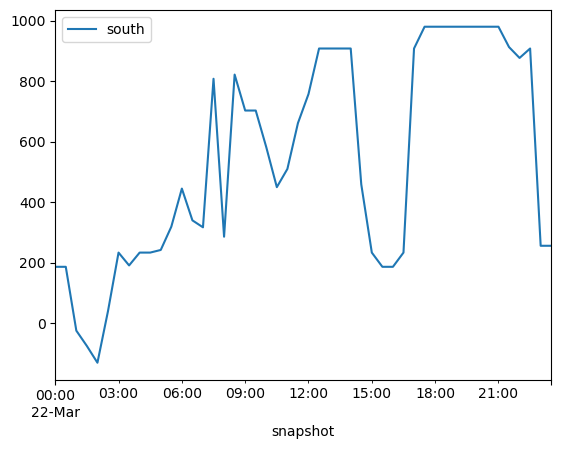

In [145]:
fig, ax = plt.subplots()

# get_water_balancing(nat, water_south, 'bids', actual_bids).plot(ax=ax, label='bids')
# get_water_balancing(nat, water_south, 'offers', actual_offers).plot(ax=ax, label='offers')

# get_water_balancing(nat, water_north, 'bids', actual_bids).plot(ax=ax, label='bids_bal')
# get_water_balancing(nat, water_north, 'offers', actual_offers).plot(ax=ax, label='offers_bal')

# nat.storage_units_t.p[water_south].sum(axis=1).plot(ax=ax, label='south')
nat.storage_units_t.p[water_north].sum(axis=1).plot(ax=ax, label='south')

ax.legend()
plt.show()

In [110]:



# print(water_south.intersection(actual_bids.index))
# print(water_south.intersection(actual_offers.index))

Index(['CRUA-1', 'CRUA-2'], dtype='object')
Index([], dtype='object')


<Axes: xlabel='snapshot'>

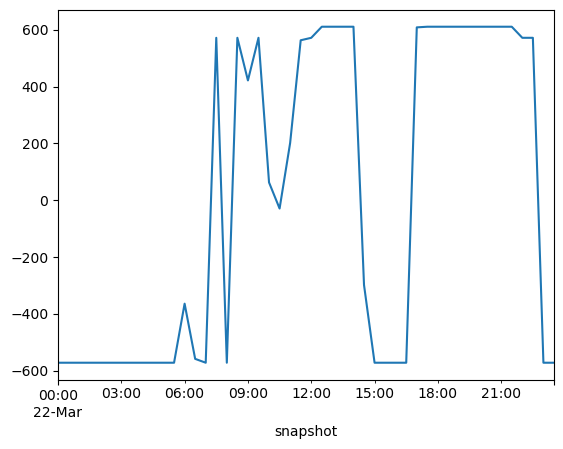

In [112]:
fig, ax = plt.subplots()
nat.storage_units_t.p[water_south].sum(axis=1).plot(ax=ax, label='nat')

In [106]:

getattr(nat, comp+'_t').p[wind_south].multiply(
    * 0.5
    )

TypeError: pandas.core.frame.DataFrame.mul() argument after * must be an iterable, not float

In [49]:
dispatch.shape

(48, 56)

In [45]:
roc_values.loc[wind_south.intersection(roc_values.index)]

GFLDW-1      83.935932
MINSW-1      93.704175
EWHLW-1      89.725192
CLDNW-1      80.869213
CLDSW-1      82.389053
CLDCW-1      80.871572
PNYCW-1      80.166247
BABAW-1      71.500000
BRNLW-1      73.644185
WHILW-1      93.986301
WHILW-2      95.501299
BURBW-1     123.110488
BLLA-1       91.945194
BLLA-2       87.086997
DBAWO-1     177.567727
DBAWO-2     138.016914
DBAWO-3     207.926745
DBAWO-4     216.779183
DBAWO-5      99.187587
GAOFO-1     186.570248
GAOFO-3     187.125240
GAOFO-2     185.113217
GAOFO-4     187.299182
GNFSW-1     124.629270
GNFSW-2     124.051453
GYMRO-15    165.990094
GYMRO-17     74.854010
GYMRO-26    123.101758
GYMRO-28    157.544080
HMGTO-1     186.345199
HMGTO-2     121.237456
LARYO-1     176.091167
LARYO-2     176.161489
LARYO-3     174.804851
LARYO-4     176.431825
LNCSO-1     140.774980
LNCSO-2     115.600594
RCBKO-1     152.561247
RCBKO-2     152.043000
RMPNO-1     164.504314
RMPNO-2     156.692995
RREW-1      128.765371
RRWW-1      147.274749
SHRSO-1    

<Axes: xlabel='snapshot'>

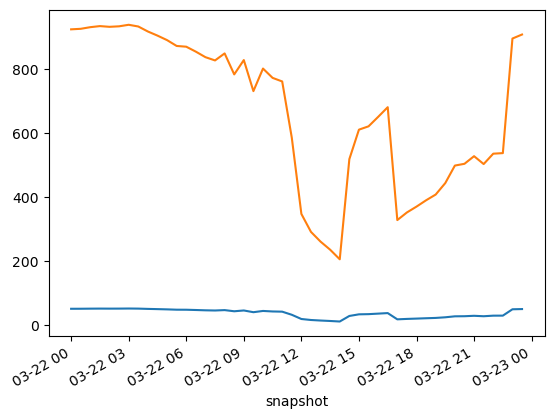

In [33]:
if actual_wind_south_balancing > 0:
    adjusted_south_wind = (
        (wsd := diff[wind_south].sum(axis=1)) / wsd.sum() *
        actual_wind_south_balancing
    )

    transfer_south_wind = wsd - adjusted_south_wind





fig, ax = plt.subplots()
ax.plot(adjusted_south_wind, label='Adjusted')
wsd.plot(ax=ax, label='Unadjusted')




In [ ]:
diff

revenues.loc[]

In [13]:
water_south

Index(['CRUA-1', 'CRUA-2', 'CRUA-3', 'CRUA-4', 'DINO-1', 'DINO-6', 'DINO-5',
       'DINO-4', 'DINO-3', 'DINO-2', 'RHEI-4'],
      dtype='object', name='StorageUnit')

In [14]:
roc_values.index.intersection(disp_south)

Index([], dtype='object')

In [ ]:
wind_south_balancing = diff[wind_south].sum(axis=1).mul(0.5).sum()




In [ ]:





disp_south_balancing = diff[disp_south].sum(axis=1).mul(0.5).sum()

<Axes: xlabel='snapshot'>

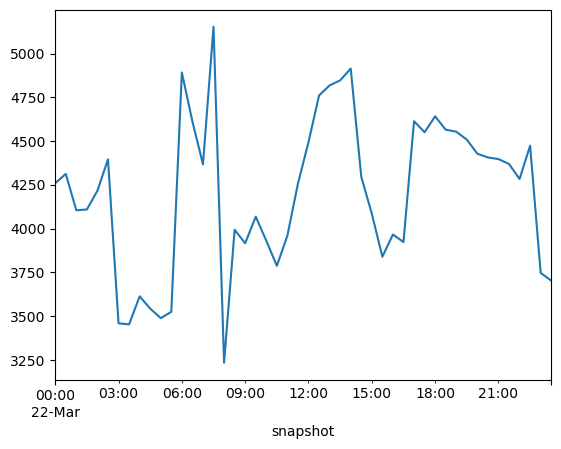

In [16]:
diff[disp_south].sum(axis=1).plot()

In [301]:
actual_offers

,price,vol
KEAD-2,81.246667,1028.700000
AG-HEL0DN,84.000000,12.250000
CARR-2,87.187500,2137.262132
STAY-3,114.526316,1538.366667
SEAB-2,136.411765,1889.600000
PEMB-51,137.000000,5256.000000
DRAXX-2,147.100000,2126.416667
LAGA-1,155.380952,1805.641667


In [302]:
actual_offers.index.intersection(disp_south)

Index(['KEAD-2', 'CARR-2', 'STAY-3', 'SEAB-2', 'PEMB-51', 'DRAXX-2', 'LAGA-1'], dtype='object')

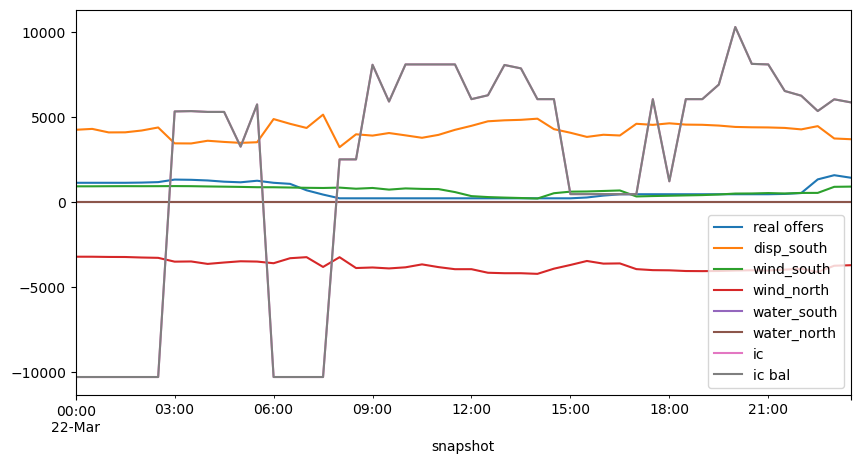

In [303]:
idx = pd.IndexSlice

fig, ax = plt.subplots(1, 1, figsize=(10, 5))


po = offers.loc[idx[:,'vol'], :].sum(axis=1).mul(2)
po.index = po.index.droplevel(1)

po.plot(ax=ax, label='real offers')

diff[disp_south].sum(axis=1).plot(ax=ax, label='disp_south')
diff[wind_south].sum(axis=1).plot(ax=ax, label='wind_south')
diff[wind_north].sum(axis=1).plot(ax=ax, label='wind_north')

diff[water_south].sum(axis=1).plot(ax=ax, label='water_south')
diff[water_north].sum(axis=1).plot(ax=ax, label='water_north')

nat.links_t.p0.loc[:,nat.links.index[nat.links.carrier == 'interconnector']].sum(axis=1).plot(ax=ax, label='ic')
bal.links_t.p0.loc[:,bal.links.index[bal.links.carrier == 'interconnector']].sum(axis=1).plot(ax=ax, label='ic bal')

ax.legend()

plt.show()

In [287]:
bal.links_t.p0.loc[:,bal.links.index[bal.links.carrier == 'interconnector']]

Link,BritNed,IFA1,IFA2,Nemo,Viking,ElecLink,NSL
snapshot,,,,,,,
2024-03-23 00:00:00,-1044.000000,2000.0,2022.0,1045.0,-641.776309,1000.0,1400.000000
2024-03-23 00:30:00,-1044.000000,2000.0,2022.0,1045.0,-570.575994,1000.0,1400.000000
2024-03-23 01:00:00,-1044.000000,2000.0,2022.0,1045.0,-737.059651,1000.0,1400.000000
2024-03-23 01:30:00,-1044.000000,2000.0,2022.0,1045.0,-962.768696,1000.0,1400.000000
2024-03-23 02:00:00,-986.460556,2000.0,2022.0,1045.0,-1400.000000,1000.0,1400.000000
2024-03-23 02:30:00,-1044.000000,2000.0,2022.0,1045.0,-807.430912,1000.0,1400.000000
2024-03-23 03:00:00,-1044.000000,2000.0,2022.0,1045.0,-1400.000000,1000.0,1118.704100
2024-03-23 03:30:00,-1044.000000,2000.0,2022.0,1045.0,-1400.000000,1000.0,1148.880674
2024-03-23 04:00:00,-1044.000000,2000.0,2022.0,1045.0,-1400.000000,1000.0,851.122587


In [ ]:
bal.

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [2024-03-23 00:00:00, 2024-03-23 00:30:00, 2024-03-23 01:00:00, 2024-03-23 01:30:00, 2024-03-23 02:00:00, 2024-03-23 02:30:00, 2024-03-23 03:00:00, 2024-03-23 03:30:00, 2024-03-23 04:00:00, 2024-03-23 04:30:00, 2024-03-23 05:00:00, 2024-03-23 05:30:00, 2024-03-23 06:00:00, 2024-03-23 06:30:00, 2024-03-23 07:00:00, 2024-03-23 07:30:00, 2024-03-23 08:00:00, 2024-03-23 08:30:00, 2024-03-23 09:00:00, 2024-03-23 09:30:00, 2024-03-23 10:00:00, 2024-03-23 10:30:00, 2024-03-23 11:00:00, 2024-03-23 11:30:00, 2024-03-23 12:00:00, 2024-03-23 12:30:00, 2024-03-23 13:00:00, 2024-03-23 13:30:00, 2024-03-23 14:00:00, 2024-03-23 14:30:00, 2024-03-23 15:00:00, 2024-03-23 15:30:00, 2024-03-23 16:00:00, 2024-03-23 16:30:00, 2024-03-23 17:00:00, 2024-03-23 17:30:00, 2024-03-23 18:00:00, 2024-03-23 18:30:00, 2024-03-23 19:00:00, 2024-03-23 19:30:00, 2024-03-23 20:00:00, 2024-03-23 20:30:00, 2024-03-23 21:00:00, 2024-03-23 21:30:00, 2024-03-23 22:00:00, 2024

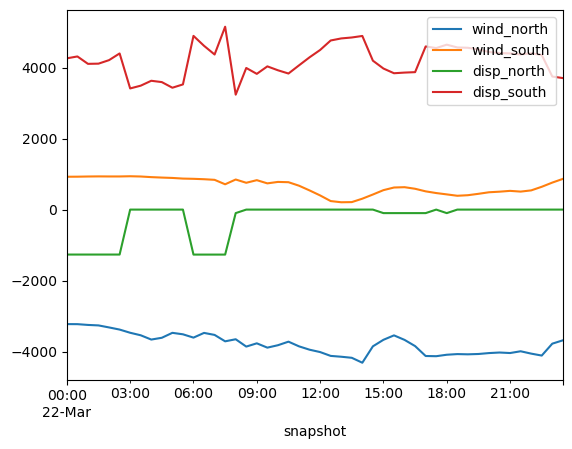

In [178]:
fig, ax = plt.subplots()
diff[wind_north].sum(axis=1).plot(ax=ax, label='wind_north')
diff[wind_south].sum(axis=1).plot(ax=ax, label='wind_south')
diff[disp_north].sum(axis=1).plot(ax=ax, label='disp_north')
diff[disp_south].sum(axis=1).plot(ax=ax, label='disp_south')
ax.legend()
plt.show()

In [207]:
actual_bids.loc[actual_bids.index.intersection(wind_north)].head()

,price,vol
BTUIW-3,21.530000,779.789224
GORDW-2,21.921042,891.615119
SGRWO-2,27.020000,1655.387584
SGRWO-6,27.020000,8588.729079
SGRWO-5,27.020000,1894.804982


In [211]:
# weighted average price
weighted_avg_bid_price = get_weighted_avg_price(actual_bids)
weighted_avg_offer_price = get_weighted_avg_price(actual_offers)

print(weighted_avg_bid_price)
print(actual_bids['price'].mean())

print(weighted_avg_offer_price)
print(actual_offers['price'].mean())

52.286356398367126
51.60827072421528
127.78884614779705
117.85664994287188


NameError: name 'southern_wind' is not defined

In [198]:
actual_bids.loc[actual_bids.index.intersection(wind_south)]

,price,vol
BABAW-1,71.500000,1198.500000
CLDCW-1,95.152857,360.141667
CLDNW-1,94.840000,190.491667
CLDSW-1,96.750000,34.333333


In [167]:
diff

,ABERU-1,ABRBO-1,ABRTW-1,ACHRW-1,AFTOW-1,AG-NHAV02,AIRSW-1,AKGLW-2,AKGLW-3,ANSUW-1,...,SLOY-2,SLOY-3,SLOY-4,THMRB-1,TOLLB-1,WBURB-41,WBURB-43,WHLWB-1,WISHB-1,ZEN02A
snapshot,,,,,,,,,,,,,,,,,,,,,
2024-03-22 00:00:00,0.0,-4.20,36.0,19.5,39.0,46.0,-0.8,62.0,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 00:30:00,0.0,-4.00,36.0,20.5,39.0,46.0,-0.8,62.0,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 01:00:00,0.0,-4.10,36.0,21.5,40.0,46.0,-0.9,62.5,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 01:30:00,0.0,-4.05,36.0,23.0,41.0,46.0,-0.9,63.0,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 02:00:00,0.0,-4.10,36.0,31.6,43.0,46.0,-0.9,63.0,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 02:30:00,0.0,-4.15,36.0,37.5,43.0,46.0,-1.0,63.0,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 03:00:00,0.0,-4.50,36.0,38.5,44.0,-0.0,-1.0,63.0,81.0,-1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 03:30:00,0.0,-4.75,36.0,39.0,44.0,-0.0,-1.0,63.0,81.0,-1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-22 04:00:00,0.0,-5.50,36.0,39.0,44.0,-0.0,-1.0,63.0,81.0,-1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
lat_bidding_threshold = 55.3 # groups dispatchable generators into north and south

water = nat.storage_units.index[nat.storage_units.carrier.isin(['cascade', 'hydro'])]
solar = nat.generators.index[nat.generators.carrier.str.contains('solar')]

gen = bal.generators
gen['y'] = gen.bus.map(bal.buses.y)

dispatchable_south = gen.loc[
    (gen.carrier.isin(['fossil', 'biomass', 'coal'])) &
    (gen['y'] <= lat_bidding_threshold)
].index
dispatchable_north = gen.loc[
    (gen.carrier.isin(['fossil', 'biomass', 'coal'])) &
    (gen['y'] > lat_bidding_threshold)
].index

wind_south = gen.loc[
    (gen.carrier.str.contains('wind')) &
    (gen['y'] <= lat_bidding_threshold)
].index
wind_north = gen.loc[
    (gen.carrier.str.contains('wind')) &
    (gen['y'] > lat_bidding_threshold)
].index


In [125]:
nat.generators_t.p.shape

(48, 307)

In [126]:
bal.generators_t.p.shape

(48, 307)

In [215]:
wind_south

Index(['GFLDW-1', 'MINSW-1', 'EWHLW-1', 'CLDNW-1', 'CLDSW-1', 'CLDCW-1',
       'PNYCW-1', 'BABAW-1', 'BRNLW-1', 'WHILW-1', 'WHILW-2', 'BURBW-1',
       'BLLA-1', 'BLLA-2', 'BRBEO-1', 'DBAWO-1', 'DBAWO-2', 'DBAWO-3',
       'DBAWO-4', 'DBAWO-5', 'DDGNO-1', 'DDGNO-2', 'DDGNO-3', 'DDGNO-4',
       'EAAO-1', 'EAAO-2', 'GAOFO-1', 'GAOFO-3', 'GAOFO-2', 'GAOFO-4',
       'GNFSW-1', 'GNFSW-2', 'GYMRO-15', 'GYMRO-17', 'GYMRO-26', 'GYMRO-28',
       'HMGTO-1', 'HMGTO-2', 'HOWAO-1', 'HOWAO-2', 'HOWAO-3', 'HOWBO-1',
       'HOWBO-2', 'HOWBO-3', 'LARYO-1', 'LARYO-2', 'LARYO-3', 'LARYO-4',
       'LNCSO-1', 'LNCSO-2', 'RCBKO-1', 'RCBKO-2', 'RMPNO-1', 'RMPNO-2',
       'RREW-1', 'RRWW-1', 'SHRSO-1', 'SHRSO-2', 'TKNEW-1', 'TKNWW-1',
       'WDNSO-1', 'WDNSO-2', 'WLNYO-2', 'WLNYO-3', 'WLNYO-4', 'WLNYW-1',
       'WTMSO-1', 'THNTO-2', 'THNTO-1', 'GRGBW-1', 'GRGBW-2', 'GRGBW-3',
       'OMNDO-1'],
      dtype='object', name='Generator')

In [128]:
bidding_volume = pd.Series(0, nat.snapshots)

In [129]:
vols = []

for plant in [wind_south, wind_north, solar, dispatchable_south, dispatchable_north]:
    
    plants_total = (
        nat.generators_t.p[plant].sum(axis=1) -
        bal.generators_t.p[plant].sum(axis=1)
    ).clip(lower=0).mul(0.5)

    bidding_volume += plants_total
    vols.append(plants_total)

water = (
    water
    .intersection(bal.storage_units_t.p.columns)
    .intersection(nat.storage_units_t.p.columns)
)

plants_total = (
    nat.storage_units_t.p[water].sum(axis=1) -
    bal.storage_units_t.p[water].sum(axis=1)
).clip(lower=0).mul(0.5)

bidding_volume += plants_total
vols.append(plants_total)

bidding_volume.sum() * 0.5

48672.919182228

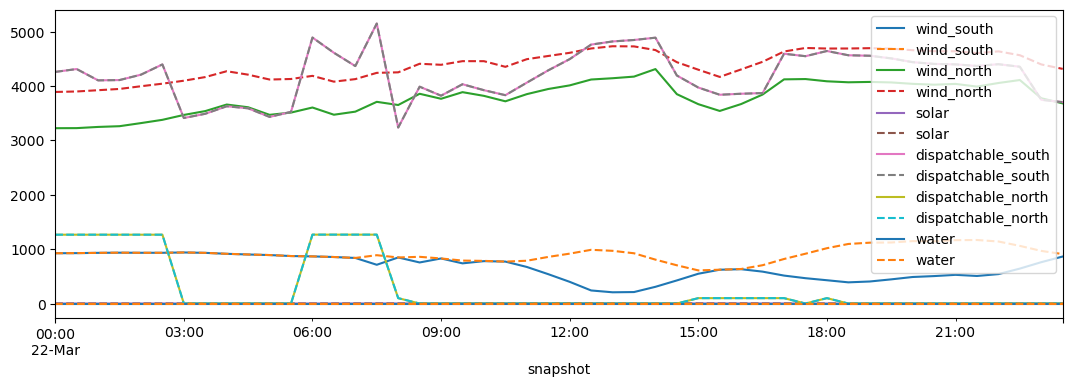

In [130]:
fig, ax = plt.subplots(figsize=(13, 4))

labels = ['wind', 'solar', 'dispatchable_south', 'dispatchable_north', 'water']

for index, label in zip(
    [wind_south, wind_north, solar, dispatchable_south, dispatchable_north, water],
    ['wind_south', 'wind_north', 'solar', 'dispatchable_south', 'dispatchable_north', 'water']
):
    diff.loc[:,index].sum(axis=1).abs().plot(ax=ax, label=label)
    diff.loc[:,index].abs().sum(axis=1).plot(ax=ax, label=label, linestyle='--')

ax.legend()
plt.show()

In [106]:
ss = nat.generators.loc[wind_south.tolist() + wind_north.tolist(), 'marginal_cost']
cfd_wind = ss.loc[ss == 0.].index

In [131]:

def get_noisy_assets(n, diff, index):

    total = diff.loc[:, index].sum().sum()

    assert np.abs(total) > 0
    tendency = total / np.abs(total)

    asset_tendency = diff.loc[:, index].sum()

    counter_currenters = asset_tendency.loc[asset_tendency.mul(tendency) < 0].index
    currenters = asset_tendency.loc[asset_tendency.mul(tendency) > 0].index

    
    print(len(index))
    print(len(counter_currenters))
    print(len(cfd_wind))
    print(counter_currenters)
    print(counter_currenters.intersection(cfd_wind))

    for cc in counter_currenters:

        total_cc = abs(100 * np.around(diff[cc].sum() / total, decimals=4))

        print(cc)
        print(total_cc)

    print('==============================')
    for cc in currenters:

        total_cc = abs(100 * np.around(diff[cc].sum() / total, decimals=4))

        print(cc)
        print(total_cc)




get_noisy_assets(nat, diff, wind_south)

73
2
29
Index(['CLDNW-1', 'CLDCW-1'], dtype='object', name='Generator')
Index([], dtype='object', name='Generator')
CLDNW-1
8.19
CLDCW-1
7.33
GFLDW-1
0.29
MINSW-1
0.44999999999999996
EWHLW-1
0.33
CLDSW-1
0.4
PNYCW-1
1.59
BABAW-1
0.75
WHILW-1
3.55
WHILW-2
2.25
BURBW-1
0.9400000000000001
BLLA-1
1.21
BLLA-2
0.7100000000000001
BRBEO-1
3.39
DDGNO-1
1.16
DDGNO-2
0.9199999999999999
DDGNO-3
1.08
DDGNO-4
1.11
EAAO-2
3.85
GAOFO-1
0.75
GAOFO-3
0.7799999999999999
GAOFO-2
0.79
GAOFO-4
0.72
GNFSW-1
0.44
GNFSW-2
0.24
GYMRO-15
2.12
GYMRO-17
0.02
GYMRO-26
1.7500000000000002
GYMRO-28
1.8599999999999999
HMGTO-1
1.2
HMGTO-2
0.95
HOWAO-1
3.9600000000000004
HOWAO-2
5.66
HOWAO-3
1.71
HOWBO-1
5.87
HOWBO-2
5.27
HOWBO-3
5.87
LARYO-1
0.9299999999999999
LARYO-2
0.95
LARYO-3
0.8999999999999999
LARYO-4
0.89
LNCSO-1
1.1199999999999999
LNCSO-2
1.08
RCBKO-1
2.0500000000000003
RCBKO-2
2.1
RMPNO-1
1.5
RMPNO-2
1.28
RREW-1
1.01
RRWW-1
1.2
SHRSO-1
1.46
SHRSO-2
1.44
TKNEW-1
4.29
TKNWW-1
4.37
WDNSO-1
2.6100000000000003
WDNSO

SystemExit: 

c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [132]:
print(nat.generators.loc[wind_north.tolist() + wind_south.tolist(), 'marginal_cost'].shape)
print(len(nat.generators.loc[wind_north.tolist() + wind_south.tolist(), 'marginal_cost'].unique()))

(184,)
154


In [133]:
bal.links_t.p0.abs().max().div(bal.links.p_nom).round(3).value_counts()

1.000    219
0.618      5
0.414      4
0.957      4
0.378      4
        ... 
0.238      1
0.716      1
0.790      1
0.611      1
0.573      1
Name: count, Length: 159, dtype: int64

In [56]:
plant

Index(['AG-NHAV02', 'MARK-1', 'GRMO-1', 'PEHE-1', 'PEHE-2', 'PEHED-1'], dtype='object', name='Generator')

In [61]:
def get_variable_name(var, namespace):
    return [name for name, value in namespace.items() if value is var]

x, y = 1, 2
for plant in [wind, solar, dispatchable_south, dispatchable_north]:
    print(get_variable_name(plant, globals()))  # Output: ['x']


['wind', 'plant']
['solar', 'plant']
['dispatchable_south', 'plant']
['_', 'dispatchable_north', 'plant', '_56']
